In [1]:
import json
from pathlib import Path
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../src/utils')
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

from preprocessing import Preprocessing
from config import Config 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Variables


In [3]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## load

In [4]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [5]:
config = Config.from_file("config_notebook.yaml")
corpus = Preprocessing(
        corpus,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:06, 188.23it/s]


### tfidf

In [6]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])
vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

# Clustering
Start with default params and tied for the covariance type because of the high CPU and RAM usage with full.
TODO: try different params

In [7]:
def fit_model(model, corpus):
    model.fit(corpus)

def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, vectorizer, corpus, labels, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i)
        idx = np.where(labels == i)[0]
        if not idx.any():
            print(f"no documents in cluster {i}")
        else:
            vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[idx])
            top_words = get_top_words(vectorizer, tfidf_corpus)
            print(top_words)
            clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters
    
model = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model, tfidf_corpus.toarray())
labels = model.predict(tfidf_corpus.toarray())

clusters = print_and_get_clusters(model, vectorizer, corpus, labels)


Top terms per cluster:
Cluster 0:
('kernel', 'learning', 'data', 'regression', 'function', 'algorithm', 'method', 'rate', 'based', 'space')


Cluster 1:
('model', 'learning', 'data', 'algorithm', 'problem', 'method', 'set', 'prediction', 'random', 'approach')


Cluster 2:
('regression', 'data', 'estimator', 'model', 'method', 'dimensional', 'high', 'estimation', 'selection', 'learning')


Cluster 3:
('model', 'graphical', 'covariance', 'matrix', 'sparse', 'data', 'algorithm', 'gaussian', 'method', 'estimation')


Cluster 4:
('graph', 'learning', 'library', 'python', 'data', 'machine', 'algorithm', 'package', 'model', 'toolbox')


Cluster 5:
('causal', 'effect', 'variable', 'data', 'model', 'method', 'algorithm', 'learning', 'set', 'discovery')


Cluster 6:
('clustering', 'cluster', 'algorithm', 'graph', 'density', 'based', 'data', 'model', 'hierarchical', 'method')


Cluster 7:
('policy', 'learning', 'algorithm', 'method', 'model', 'agent', 'reinforcement', 'problem', 'function', 'cont

some words words are similar to kmeans. But there are a lot of words which are new. But the "buzzwords" are the same and the composition of words defining a cluster are very similar to kmeans.






# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


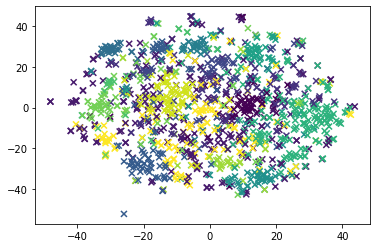

In [8]:
def plot(model, corpus, labels, n_components=None):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=labels, marker='x')
    plt.show()
plot(model, tfidf_corpus, labels)

no clusters visible

# Remove words which appear often in all clusters

In [9]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'data': 13, 'algorithm': 13, 'method': 13, 'learning': 11, 'model': 11, 'problem': 6, 'function': 3, 'regression': 2, 'based': 2, 'set': 2, 'approach': 2, 'estimation': 2, 'selection': 2, 'matrix': 2, 'gaussian': 2, 'graph': 2, 'network': 2, 'kernel': 1, 'rate': 1, 'space': 1, 'prediction': 1, 'random': 1, 'estimator': 1, 'dimensional': 1, 'high': 1, 'graphical': 1, 'covariance': 1, 'sparse': 1, 'library': 1, 'python': 1, 'machine': 1, 'package': 1, 'toolbox': 1, 'causal': 1, 'effect': 1, 'variable': 1, 'discovery': 1, 'clustering': 1, 'cluster': 1, 'density': 1, 'hierarchical': 1, 'policy': 1, 'agent': 1, 'reinforcement': 1, 'control': 1, 'rank': 1, 'low': 1, 'bound': 1, 'completion': 1, 'norm': 1, 'optimization': 1, 'stochastic': 1, 'gradient': 1, 'convex': 1, 'loss': 1, 'community': 1, 'detection': 1, 'recovery': 1, 'block': 1, 'neural': 1, 'node': 1, 'layer': 1, 'structure': 1, 'ranking': 1, 'comparison': 1, 'pairwise': 1, 'preference':

most common words are similar to kmeans

In [10]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [11]:
corpus_new = load_data()

config = Config.from_file("config_notebook_stopwords.yaml")
corpus_stopwords = Preprocessing(
        corpus_new,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:05, 211.29it/s]


In [12]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [13]:
model_stopwords = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_stopwords, tfidf_corpus_stopwords.toarray())
labels_stopwords = model_stopwords.predict(tfidf_corpus_stopwords.toarray())

clusters_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, corpus_stopwords, labels_stopwords)

Top terms per cluster:
Cluster 0:
('stochastic', 'gradient', 'convex', 'function', 'optimization', 'convergence', 'regression', 'problem', 'non', 'rate')


Cluster 1:
('graph', 'problem', 'dag', 'function', 'random', 'based', 'distribution', 'result', 'clustering', 'time')


Cluster 2:
('kernel', 'regression', 'function', 'based', 'problem', 'estimator', 'distributed', 'rate', 'mean', 'space')


Cluster 3:
('gaussian', 'inference', 'process', 'variational', 'approach', 'bayesian', 'approximation', 'distribution', 'prior', 'posterior')


Cluster 4:
('clustering', 'density', 'subspace', 'cluster', 'based', 'estimation', 'spectral', 'hierarchical', 'problem', 'set')


Cluster 5:
('policy', 'iteration', 'action', 'based', 'gradient', 'problem', 'function', 'task', 'search', 'space')


Cluster 6:
('causal', 'variable', 'latent', 'effect', 'set', 'inference', 'approach', 'tensor', 'discovery', 'condition')


Cluster 7:
('lasso', 'sparse', 'selection', 'matrix', 'regression', 'high', 'covaria

In [14]:
terms = list(itertools.chain.from_iterable(clusters_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 10, 'function': 5, 'based': 5, 'regression': 4, 'distribution': 4, 'set': 4, 'rate': 3, 'estimator': 3, 'bound': 3, 'gradient': 2, 'convex': 2, 'optimization': 2, 'result': 2, 'clustering': 2, 'time': 2, 'distributed': 2, 'space': 2, 'inference': 2, 'approach': 2, 'approximation': 2, 'task': 2, 'tensor': 2, 'matrix': 2, 'optimal': 2, 'loss': 2, 'machine': 2, 'feature': 2, 'sample': 2, 'stochastic': 1, 'convergence': 1, 'non': 1, 'graph': 1, 'dag': 1, 'random': 1, 'kernel': 1, 'mean': 1, 'gaussian': 1, 'process': 1, 'variational': 1, 'bayesian': 1, 'prior': 1, 'posterior': 1, 'density': 1, 'subspace': 1, 'cluster': 1, 'estimation': 1, 'spectral': 1, 'hierarchical': 1, 'policy': 1, 'iteration': 1, 'action': 1, 'search': 1, 'causal': 1, 'variable': 1, 'latent': 1, 'effect': 1, 'discovery': 1, 'condition': 1, 'lasso': 1, 'sparse': 1, 'selection': 1, 'high': 1, 'covariance': 1, 'dimensional': 1, 'graphical': 1, 'risk': 1, 'ranking': 1

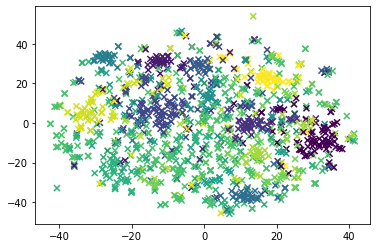

In [15]:
plot(model_stopwords, tfidf_corpus_stopwords, labels_stopwords)

Cluster looks a little bit better than before? But still not good. 

# LSA
- With LSA the calculation time is much less.
- TODO: find optimal n_components

In [16]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

test for optimal n_components

In [19]:
def calc_scores_arr(corpus, model, labels):
    return metrics.silhouette_score(corpus, labels, metric='euclidean'), metrics.calinski_harabasz_score(corpus, labels), metrics.davies_bouldin_score(corpus, labels)

def calc_scores(corpus, model, labels):
    return calc_scores_arr(corpus.toarray(), model, labels)

def plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(n, silhouettes_scores)
    ax1.set_title('silhouettes_score')
    ax2.plot(n, calinski_harabasz_scores, label="calinski_harabasz_scores")
    ax2.set_title('calinski_harabasz_scores')
    ax3.plot(n, davies_bouldin_scores, label="davies_bouldin_scores")
    ax3.set_title('davies_bouldin_scores')
    plt.show()
    

def find_n_components_lsa():
    n = [2,5,10,15,20,25,30]
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        X, svd = get_lsa_transformation(n_component, tfidf_corpus)
        model_lsa = GaussianMixture(n_components=num_topics, covariance_type="tied")
        fit_model(model_lsa, X)
        labels_lsa = model_lsa.predict(X)
        score = list(calc_scores_arr(X, model_lsa, labels_lsa))

        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

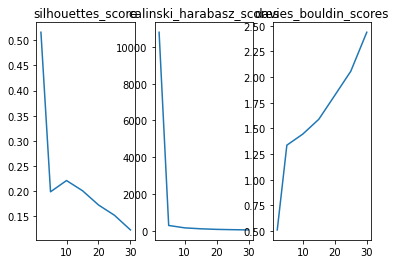

In [20]:
find_n_components_lsa()

In [21]:
n_components = 2
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_lsa, X)
labels_lsa = model_lsa.predict(X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, corpus, labels_lsa, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('data', 'algorithm', 'learning', 'method', 'model', 'problem', 'feature', 'cluster', 'set', 'matrix')


Cluster 1:
('algorithm', 'method', 'bound', 'problem', 'rate', 'learning', 'convex', 'regret', 'kernel', 'convergence')


Cluster 2:
('model', 'data', 'network', 'latent', 'causal', 'method', 'graph', 'algorithm', 'variable', 'gaussian')


Cluster 3:
('learning', 'algorithm', 'matrix', 'problem', 'method', 'regression', 'data', 'bound', 'rank', 'optimal')


Cluster 4:
('model', 'data', 'learning', 'graph', 'algorithm', 'feature', 'method', 'bayesian', 'inference', 'gaussian')


Cluster 5:
('algorithm', 'kernel', 'function', 'learning', 'method', 'policy', 'problem', 'loss', 'regression', 'gradient')


Cluster 6:
('data', 'learning', 'algorithm', 'method', 'model', 'problem', 'matrix', 'class', 'distribution', 'function')


Cluster 7:
('model', 'graph', 'network', 'causal', 'graphical', 'inference', 'data', 'latent', 'learning', 'community')


Cluste

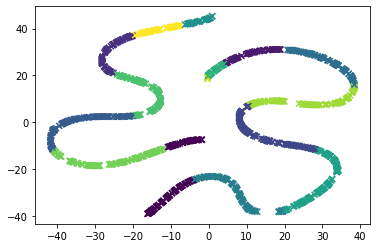

In [22]:
plot(model_lsa, X, labels_lsa, n_components=n_components)

In [23]:
n_components = 2
X_stopwords, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
model_lsa_stopwords = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_lsa_stopwords, X_stopwords)
labels_lsa_stopwords = model_lsa_stopwords.predict(X_stopwords)
clusters_with_lsa_stopwords = print_and_get_clusters(model_lsa_stopwords, vectorizer_stopwords, corpus_stopwords, labels_lsa_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('gaussian', 'based', 'inference', 'feature', 'problem', 'approach', 'task', 'prediction', 'set', 'clustering')


Cluster 1:
('kernel', 'regression', 'matrix', 'function', 'problem', 'rank', 'optimization', 'loss', 'norm', 'online')


Cluster 2:
('graph', 'causal', 'network', 'inference', 'effect', 'community', 'markov', 'equivalence', 'variable', 'vertex')


Cluster 3:
('matrix', 'problem', 'set', 'dimensional', 'based', 'result', 'high', 'approach', 'distribution', 'kernel')


Cluster 4:
('network', 'graph', 'graphical', 'set', 'problem', 'feature', 'latent', 'based', 'gaussian', 'time')


Cluster 5:
('matrix', 'bound', 'problem', 'regression', 'function', 'kernel', 'optimal', 'estimator', 'linear', 'optimization')


Cluster 6:
('stochastic', 'convex', 'gradient', 'rate', 'problem', 'optimization', 'bound', 'function', 'convergence', 'loss')


Cluster 7:
('network', 'graph', 'causal', 'variable', 'latent', 'inference', 'neural', 'graphical', 'python'

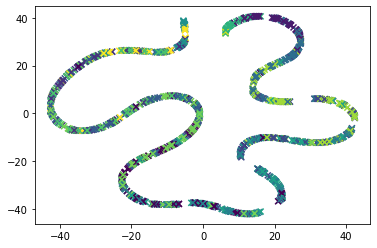

In [24]:
plot(model_lsa_stopwords, X_stopwords, labels_lsa, n_components=n_components)

# Spectral Embedding

In [25]:
def find_n_components_spectral():
    n = [2,5,10,15,20,25,30]
    vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
    tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=n_component).fit_transform(tfidf_corpus_spec_embedding.toarray())
        model_spectral = GaussianMixture(n_components=num_topics, covariance_type="tied")
        model_spectral.fit(tfidf_corpus_spec_embedding_array)
        labels_spectral = model_spectral.predict(tfidf_corpus_spec_embedding_array)

        score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral, labels_spectral))
        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

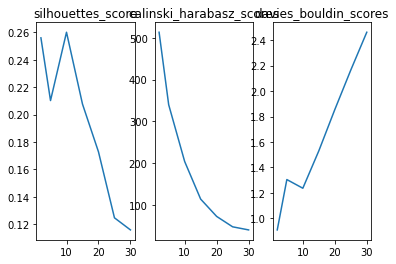

In [26]:
find_n_components_spectral()

2 is best

In [27]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [28]:
model_spectral = GaussianMixture(n_components=num_topics, covariance_type="tied")
model_spectral.fit(tfidf_corpus_spec_embedding_array)

GaussianMixture(covariance_type='tied', n_components=15)

In [29]:
labels_spectral = model_spectral.predict(tfidf_corpus_spec_embedding_array)
print(np.where(labels_spectral == 0))
clusters_spectral = print_and_get_clusters(model_spectral, vectorizer_spec_embedding, corpus, labels_spectral)

(array([   0,    2,    3,    9,   13,   17,   24,   38,   39,   41,   44,
         52,   54,   55,   62,   74,   80,   82,   85,   88,   91,   92,
         94,   97,   99,  101,  111,  112,  118,  127,  135,  136,  151,
        160,  164,  171,  173,  177,  182,  195,  197,  198,  210,  211,
        213,  234,  252,  255,  272,  275,  280,  284,  289,  293,  294,
        295,  300,  304,  312,  315,  316,  318,  321,  330,  332,  338,
        343,  345,  353,  356,  357,  360,  369,  373,  387,  389,  391,
        393,  394,  401,  403,  404,  409,  415,  421,  423,  425,  426,
        439,  440,  446,  447,  448,  451,  452,  463,  464,  465,  467,
        470,  471,  472,  473,  474,  480,  484,  488,  491,  493,  497,
        499,  504,  512,  527,  531,  536,  540,  549,  550,  552,  581,
        582,  584,  596,  599,  601,  603,  609,  618,  634,  636,  638,
        646,  647,  650,  653,  661,  669,  679,  686,  698,  703,  704,
        713,  714,  719,  721,  725,  726,  728,  

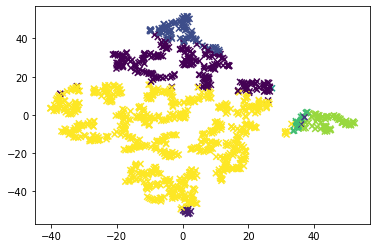

In [30]:
plot(model_spectral, tfidf_corpus_spec_embedding_array, labels_spectral, n_components=2)

Only 5 clusters found.

# find k

In [31]:
def find_k():
    ks = [2,5,10,15,20,25,30]
    vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
    tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for k in ks:
        tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())
        model_spectral = GaussianMixture(n_components=k, covariance_type="tied")
        model_spectral.fit(tfidf_corpus_spec_embedding_array)
        labels_spectral = model_spectral.predict(tfidf_corpus_spec_embedding_array)

        score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral, labels_spectral))
        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, ks)

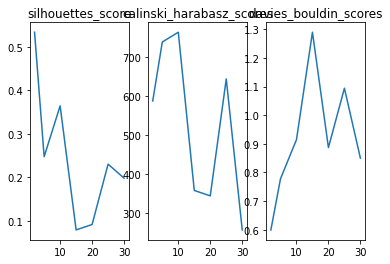

In [32]:
find_k()

# Metrics
Metrics provided from sklearn, that don't need true labels:

    metrics.silhouette_score
    metrics.calinski_harabasz_score
    metrics.davies_bouldin_score
    
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [34]:
scores = []
score = list(calc_scores(tfidf_corpus, model, labels))
score.insert(0, 'normal model')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords, labels_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)
score = list(calc_scores_arr(X, model_lsa, labels_lsa))
score.insert(0, 'model_lsa')
scores.append(score)
score = list(calc_scores_arr(X_stopwords, model_lsa_stopwords, labels_lsa_stopwords))
score.insert(0, 'model_lsa_stopwords')
scores.append(score)
score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral, labels_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.011504                 4.669509   
1    model with custom stopwords          0.010823                 4.724219   
2                      model_lsa          0.528596             10893.763216   
3            model_lsa_stopwords          0.522444             10053.796069   
4  model with spectral embedding          0.078983               334.756555   

   davies_bouldin_score  
0              7.442847  
1              7.369633  
2              0.504863  
3              0.507149  
4              1.492378  


- kmeans achieves better scores. But with LSA the scores are better than the score of kmeans with lsa.
- the scores with spectral embedding are good, but not as good as with kmeans or birch.

In [ ]:
scores.to_csv("scores/gaussian_mixture.csv")